In [196]:
import gc
import os
import random
import sys
import time
import math

import nltk
import torch.nn as nn

import pandas as pd
import torch
from PIL import Image
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from torchvision import transforms
import re
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.functional as F
from collections import defaultdict
from itertools import product
from textblob import TextBlob

warnings.filterwarnings("ignore", category=UserWarning)  # Disable UserWarnings
tqdm.pandas()

In [197]:
train_df = pd.read_csv("./dataset/train.csv")
test_df = pd.read_csv("./dataset/test.csv")
validation_df = pd.read_csv("./dataset/val.csv")

In [198]:
import text_preprocessing

train_df['preprocessed_text'] = train_df['caption'].progress_apply(text_preprocessing.text_preparetion_simple)
validation_df['preprocessed_text'] = validation_df['caption'].progress_apply(text_preprocessing.text_preparetion_simple)
test_df['preprocessed_text'] = test_df['caption'].progress_apply(text_preprocessing.text_preparetion_simple)

100%|██████████| 2000/2000 [00:00<00:00, 394813.76it/s]


In [199]:
train_df

,id,caption,image_id,label,preprocessed_text
0,417812c5-0ce4-499d-b97d-4d28827239bc,Wet elephants shake water onto people bathing ...,394330,0,wet elephants shake water onto people bathing ...
1,5ac91fa3-55f2-4cb3-8c8f-ad84f78e6b36,Two men holding tennis racquets on the court,130849,0,two men holding tennis racquets on the court
2,d2705b90-8347-4cab-a7a6-654540d9a489,A bird on a tree limb with mountains in the ba...,514790,0,a bird on a tree limb with mountains in the ba...
3,a3b33fe7-3085-4433-9c18-8814803891b4,A kitchen and dining room are featured along w...,182096,0,a kitchen and dining room are featured along w...
4,1514b0e4-0665-45bc-ab32-52fce326cc29,A fruit stand has various fruits on the table.,68788,1,a fruit stand has various fruits on the table
...,...,...,...,...,...
9995,1d1df243-485d-4b29-82c8-7e34c0de1f5c,Several people stand in a field flying a kite.,522702,0,several people stand in a field flying a kite
9996,f7dfa883-e524-4974-b5ba-6b3c3db49087,A batter hitting a pitch at a baseball game.,441874,1,a batter hitting a pitch at a baseball game
9997,602e83dc-6539-4c1a-8d19-c1481b5c24bf,A person on white surfboard next to group in a...,166716,0,a person on white surfboard next to group in a...
9998,d9ce2e8c-0831-466a-8756-4c40d772b1ce,A baseball player getting ready to swing at th...,517601,0,a baseball player getting ready to swing at th...


In [200]:
def initialize_tfidf(sentences, max_features=None):
    """
    Initialize and fit a TF-IDF vectorizer with given sentences.
    
    Args:
        sentences (list of str): Sentences to vectorize.
        max_features (int): Maximum number of features (vocabulary size).
    
    Returns:
        TfidfVectorizer: A fitted TF-IDF vectorizer.
    """
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 3),  # Include unigrams, bigrams, and trigrams for richer context
        max_df=0.9,  # Ignore terms that appear in more than 90% of documents (common words)
        min_df=3,  # Include terms appearing in at least 3 documents (remove rare noise))
    )
    vectorizer.fit(sentences)
    return vectorizer


# Vectorize a sentence using the TF-IDF vectorizer
def vectorize_sentence(sentence, vectorizer):
    """
    Converts a sentence into a sparse tensor of TF-IDF values using a given vectorizer.
    
    Args:
        sentence (str): Input sentence.
        vectorizer (TfidfVectorizer): TF-IDF vectorizer.
        
    Returns:
        torch.Tensor: Vectorized sentence as a tensor.
    """
    vector = vectorizer.transform([sentence])
    return torch.tensor(vector.toarray(), dtype=torch.float32).squeeze(0)


# Custom Dataset Class
class TFIDFDataset(Dataset):
    def __init__(self, dataframe, vectorizer, images_path, train=True, augmentation_prob=0.3):
        """
        Dataset for preprocessing image-text pairs with TF-IDF vectorization.

        Args:
            dataframe (pd.DataFrame): DataFrame containing 'image_id', 'sentence', and optionally 'label'.
            vectorizer (TfidfVectorizer): TF-IDF vectorizer for text.
            images_path (str): Base path to the images.
            train (bool): Whether this is a training dataset.
            max_len (int): Maximum length for sentences in terms of features. Truncation isn't typical with TF-IDF.
        """
        super().__init__()
        self.dataframe = dataframe
        self.vectorizer = vectorizer
        self.train = train
        self.images_path = images_path
        self.augmentation_prob = augmentation_prob
        # Define image transformations
        self.image_transform = transforms.Compose([
            transforms.RandomResizedCrop(100, scale=(0.8, 1.0)),
            # transforms.RandomVerticalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        sentence = row['caption']

        if random.random() < self.augmentation_prob:
            # sentence = self.augment_text(sentence)
            sentence = self.synonym_replacement(sentence)

        vectorized_sentence = vectorize_sentence(sentence, self.vectorizer)

        # Process image
        image_path = f"{self.images_path}{row['image_id']}.jpg"
        try:
            image = Image.open(image_path).convert("RGB")  # Convert to RGB
            image = self.image_transform(image)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image not found at path: {image_path}")

        # Handle labels (for training)
        if self.train:
            label = row['label']
            return {
                'images': image,
                'captions': vectorized_sentence,
                'labels': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'images': image,
                'captions': vectorized_sentence,
                'id': row['id']
            }

    def augment_text(self, text):
        """ Augment text using synonym replacement and rephrasing. """
        if random.random() < 0.5:
            return self.synonym_replacement(text)
        else:
            return self.rephrase_text(text)


    def synonym_replacement(self, text):
        # Tokenize the sentence
        words = nltk.word_tokenize(text)
        new_words = words.copy()
    
        # Find indices of words that can be replaced
        replaceable = [i for i, word in enumerate(words) if wordnet.synsets(word)]
        
        # Randomly choose half of these words to replace
        num_to_replace = len(replaceable) // 2
        chosen_indices = random.sample(replaceable, num_to_replace)
    
        # Replace chosen words with synonyms
        for i in chosen_indices:
            synsets = wordnet.synsets(words[i])
            if synsets:
                # Choose a random synonym from the first synset
                synonyms = list(set([lemma.name() for lemma in synsets[0].lemmas() if lemma.name() != words[i]]))
                if synonyms:
                    new_words[i] = random.choice(synonyms).replace('_', ' ')

        # Reconstruct the sentence
        return ' '.join(new_words)


    def rephrase_text(self, text):
        blob = TextBlob(text)
        return str(blob.correct())

In [201]:
vectorizer = initialize_tfidf(train_df['preprocessed_text'], max_features=None)
max_len = len(vectorizer.get_feature_names_out())  # max_features
max_len

15447

In [202]:
train_dataset = TFIDFDataset(train_df, vectorizer, images_path="./dataset/train_images/", train=True)
test_dataset = TFIDFDataset(test_df, vectorizer, images_path="./dataset/test_images/", train=False)
val_dataset = TFIDFDataset(validation_df, vectorizer, images_path="./dataset/val_images/", train=True)

In [203]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [204]:
batch = next(iter(train_dataloader))
images = batch['images']
captions = batch['captions']
print(images.shape)
print(captions.shape)
print(captions[0])

torch.Size([16, 3, 100, 100])
torch.Size([16, 15447])
tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [205]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [206]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.LeakyReLU(),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [207]:
class CNN(nn.Module):
    def __init__(self, cnn_dropout_value):
        super(CNN, self).__init__()

        self.CNN_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(cnn_dropout_value),
            # SEBlock(16),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(cnn_dropout_value),
            # SEBlock(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=7, stride=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(cnn_dropout_value),
            # SEBlock(32),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.flatten = nn.Flatten()

    def forward(self, images):
        img_features = self.CNN_block(images)  # (Batch, 128, 1, 1)
        img_features = self.flatten(img_features)  # (Batch, 128)
        return img_features

In [208]:
class SEBlock1D(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock1D, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.LeakyReLU(),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

In [209]:
class TextModule(nn.Module):
    def __init__(self, cnn_dropout_value, text_features_size):
        super(TextModule, self).__init__()

        self.tfidf_feature_extract = nn.Sequential(
            nn.Linear(text_features_size, 1028),
            nn.LeakyReLU(),
            nn.Dropout(cnn_dropout_value),
            nn.Linear(1028, 256),
            nn.LeakyReLU(),
            nn.Dropout(cnn_dropout_value),
            nn.Linear(256, 128),
            nn.LeakyReLU()
        )

        self.CNN1d = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm1d(16),
            nn.Dropout(cnn_dropout_value),
            # SEBlock1D(16),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(cnn_dropout_value),
            # SEBlock1D(32),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(in_channels=32, out_channels=32, kernel_size=7, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(cnn_dropout_value),
            # SEBlock1D(32),
            nn.AdaptiveAvgPool1d(1)
        )
        self.flatten = nn.Flatten()

    def forward(self, captions):
        captions = captions.unsqueeze(1)
        text_features = self.tfidf_feature_extract(captions)
        text_features = self.CNN1d(text_features)  # 
        text_features = self.flatten(text_features)  # 
        return text_features

In [210]:
class ImageTextMatchingModel(nn.Module):
    def __init__(self, cnn_dropout_value, text_features_size):
        super(ImageTextMatchingModel, self).__init__()
        self.image_encoder = CNN(cnn_dropout_value)
        self.text_encoder = TextModule(cnn_dropout_value, text_features_size)

    def forward(self, images, captions):
        img_emb = self.image_encoder(images)
        text_emb = self.text_encoder(captions)
        return img_emb, text_emb
    
    def similarity(self, img_emb, text_emb):
        # Normalize embeddings to compute cosine similarity
        img_emb = F.normalize(img_emb, p=2, dim=1)
        text_emb = F.normalize(text_emb, p=2, dim=1)
        return torch.mm(img_emb, text_emb.t())

In [211]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, img_emb, text_emb, label):
        # Calculate Euclidean distance between embeddings
        distance = torch.nn.functional.pairwise_distance(img_emb, text_emb)
        # Contrastive loss
        loss = torch.mean((1-label) * torch.pow(distance, 2) +
                          (label) * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))
        return loss

In [212]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Embedding):
        nn.init.xavier_uniform_(m.weight)
    elif isinstance(m, nn.LayerNorm):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.TransformerEncoderLayer):
        for name, param in m.named_parameters():
            if "weight" in name:
                if param.dim() > 1:
                    nn.init.xavier_uniform_(param)
                else:
                    nn.init.ones_(param)
            elif "bias" in name:
                nn.init.zeros_(param)

In [213]:
# Initialize the model
model_config = {
    "cnn_dropout_value": 0.2,
    "text_features_size": max_len,
}
criterion = ContrastiveLoss(margin=1.0)
criterion.to(device)

model = ImageTextMatchingModel(**model_config)
model.apply(initialize_weights)
model.to(device)

ImageTextMatchingModel(
  (image_encoder): CNN(
    (CNN_block): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.2, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (6): LeakyReLU(negative_slope=0.01)
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Dropout(p=0.2, inplace=False)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(32, 32, kernel_size=(7, 7), stride=(3, 3), padding=(1, 1))
      (11): LeakyReLU(negative_slope=0.01)
      (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): Dropout(p=0.2, inplace=Fa

In [214]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion_validation = torch.nn.BCEWithLogitsLoss()
# T_0 -> Number of iterations until the first restart
# T_mult -> Double the cycle le ngth after every restart
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,  # Number of epochs before the first restart
    T_mult=1,  # Multiplicative factor for increasing restart period
    eta_min=1e-4  # Minimum learning rate
)
# lambda1 = lambda epoch: 0.95 ** epoch
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

In [215]:
import copy


def training_method(model, criterion, criterion_validation, optimizer, scheduler, num_epochs, train_loader, val_loader, patience=4, delta=0.05, loss_procentage_improvement=10):
    train_losses = []  # List to store training losses
    val_losses = []  # List to store validation losses
    val_accuracies = []  # List to store validation accuracies
    val_precisions = []  # List to store validation precisions
    val_recalls = []  # List to store validation recalls
    val_f1s = []  # List to store validation F1-scores
    learning_rates = []  # List to store learning rate progression

    best_val_loss = float('inf')  # Initialize the best validation loss
    initial_loss = float('inf')
    best_model = None  # Store the best model
    epochs_without_improvement = 0  # Track epochs without improvement

    for epoch in range(num_epochs):
        start_time = time.time()
        ### TRAINING
        model.train()
        training_loss = 0.0

        for batch in train_loader:
            images = batch['images'].to(device)  # Images from batch
            captions = batch['captions'].to(device)  # Captions from batch
            labels = batch['labels'].to(device).float()  # Binary labels (0/1), converted to float

            optimizer.zero_grad()  # Reset gradients
            img_embeddings, text_embeddings = model(images, captions)
            loss = criterion(img_embeddings, text_embeddings, labels)
            loss.backward()

            optimizer.step()  # Update weights
            training_loss += loss.item()  # Accumulate loss

        train_loss = training_loss / len(train_loader)  # Average training loss
        train_losses.append(train_loss)

        ### VALIDATING
        model.eval()
        validation_loss = 0.0
        all_labels = []  # Ground truth labels for validation
        all_preds = []  # Predictions for validation

        with torch.no_grad():
            for batch in val_loader:
                images = batch['images'].to(device)
                captions = batch['captions'].to(device)
                labels = batch['labels'].to(device).float()

                img_emb, text_emb = model(images, captions)

                # Calculate similarity scores
                similarity_scores = model.similarity(img_emb, text_emb).diagonal()
    
                # Convert similarity scores to probabilities if needed (or use them directly as scores)
                # Here, the similarity score itself can be interpreted as a probability for matching
                # so we don't necessarily apply sigmoid
    
                # Compute validation loss - we assume the criterion can handle similarity scores and labels directly
                loss = criterion_validation(similarity_scores, labels)
                validation_loss += loss.item()
    
                # Convert similarity scores to predicted labels based on a threshold
                preds = (similarity_scores > 0.5).float()
    
                # Store for statistics
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        val_loss = validation_loss / len(val_loader)  # Average validation loss
        val_losses.append(val_loss)

        # Compute validation statistics
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_precision = precision_score(all_labels, all_preds, zero_division=0)
        val_recall = recall_score(all_labels, all_preds, zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, zero_division=0)

        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        # Step the learning rate scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']  # Get the current learning rate
        learning_rates.append(current_lr)
        end_time = time.time()

        print(f"\nEpoch {epoch + 1}/{num_epochs} - "
              f"Training Loss: {train_loss:.4f} - "
              f"Validation Loss: {val_loss:.4f} - "
              f"Accuracy: {val_accuracy:.4f} - "
              f"Precision: {val_precision:.4f} - "
              f"Recall: {val_recall:.4f} - "
              f"F1 Score: {val_f1:.4f} - "
              f"Time: {end_time - start_time:.2f} - "
              f"Lr: {current_lr:.2e}")

        if epoch == 1:
            initial_loss = val_loss

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)  # Save the best model
            epochs_without_improvement = 0  # Reset counter
            print(f"New best model with Loss: {val_loss:.4f} at epoch {epoch + 1}")
        elif val_loss < best_val_loss + delta:
            print(f"Validation loss did not improve significantly")
        else:
            epochs_without_improvement += 1
            print(f"Validation loss did not improve for {epochs_without_improvement} epoch(s).")
            # Stop training if validation loss does not improve for 'patience' epochs
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1}. Best Loss: {best_val_loss:.4f}")
                break  # Exit training loop

    print('Training finished!')

    # save the model only if the best loss is lower than the first initial loss ( to see that the model actually improved with 10% loss )
    if best_val_loss < (100 - loss_procentage_improvement) * initial_loss:
        # Init plot&model save path
        plt_save_path = "models/"
        model_config['eval_loss'] = best_val_loss
        for key, value in model_config.items():
            plt_save_path += key + "=" + str(value) + "+"
        plt_save_path = plt_save_path[:-1] + ".png"
        model_path = plt_save_path[:-4] + ".pt"
        torch.save(best_model.state_dict(), model_path)
        print(f"Best model with Loss: {best_val_loss:.4f} saved.")
        print(f"Model saved to {model_path}")

        # Plotting the losses and validation metrics over epochs
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(val_accuracies, label='Accuracy')
        plt.plot(val_precisions, label='Precision')
        plt.plot(val_recalls, label='Recall')
        plt.plot(val_f1s, label='F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('Metric')
        plt.title('Validation Metrics')
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(learning_rates, label='Learning Rate')
        plt.xlabel("Epochs")
        plt.ylabel("Learning Rate")
        plt.title("Learning Rate Progression")
        plt.legend()

        plt.tight_layout()
        plt.savefig(plt_save_path)
        plt.show()

    else:
        print(f"Model wasn't saved because it didn't improve: {loss_procentage_improvement}%")


Epoch 1/100 - Training Loss: 3.2426 - Validation Loss: 0.6966 - Accuracy: 0.4997 - Precision: 0.4286 - Recall: 0.0020 - F1 Score: 0.0040 - Time: 32.42 - Lr: 1.00e-04
New best model with Loss: 0.6966 at epoch 1

Epoch 2/100 - Training Loss: 2.1890 - Validation Loss: 0.6904 - Accuracy: 0.5007 - Precision: 0.5357 - Recall: 0.0100 - F1 Score: 0.0196 - Time: 30.59 - Lr: 1.00e-04
New best model with Loss: 0.6904 at epoch 2

Epoch 3/100 - Training Loss: 1.6689 - Validation Loss: 0.6826 - Accuracy: 0.5103 - Precision: 0.8298 - Recall: 0.0260 - F1 Score: 0.0504 - Time: 30.93 - Lr: 1.00e-04
New best model with Loss: 0.6826 at epoch 3

Epoch 4/100 - Training Loss: 1.2578 - Validation Loss: 0.6759 - Accuracy: 0.5223 - Precision: 0.8073 - Recall: 0.0587 - F1 Score: 0.1094 - Time: 30.38 - Lr: 1.00e-04
New best model with Loss: 0.6759 at epoch 4

Epoch 5/100 - Training Loss: 0.9580 - Validation Loss: 0.6799 - Accuracy: 0.5400 - Precision: 0.7500 - Recall: 0.1200 - F1 Score: 0.2069 - Time: 30.35 - Lr

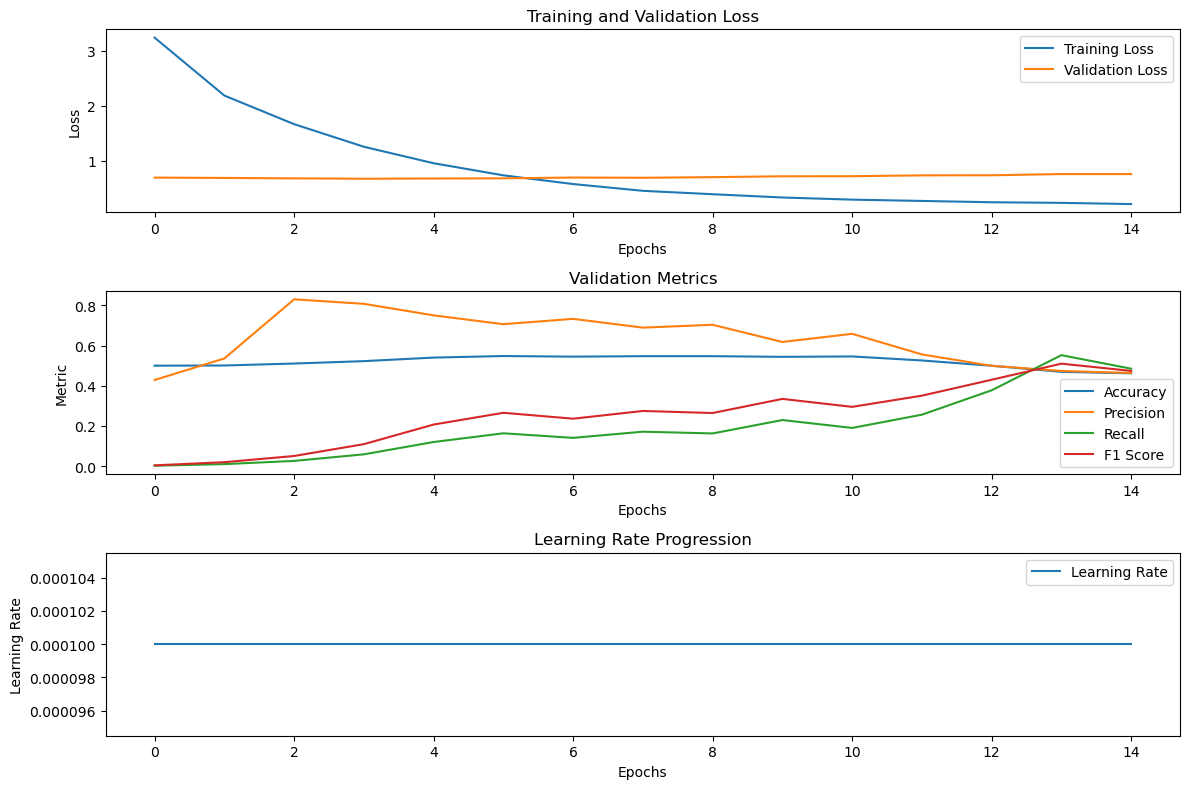

In [216]:
training_method(model, criterion, criterion_validation, optimizer, scheduler, num_epochs=100, train_loader=train_dataloader, val_loader=val_dataloader)

In [217]:
ids = []
predictions = []


def make_submission(model, test_loader):
    model.eval()

    with torch.no_grad():
        for batch in tqdm(test_loader):
            images = batch['images'].to(device)
            captions = batch['captions'].to(device)
            id = batch['id']

            output = model(images, captions)
            preds = (torch.sigmoid(output) > 0.5).int()

            ids.extend(id)
            predictions.extend(preds.cpu().tolist())
    df = pd.DataFrame({'id': ids, 'label': predictions})
    df.to_csv('submission3.csv', index=False)

In [218]:
# # LOAD MODEL FROM PATH
# model_config = {
#     "vocab_size": len(vocab),
#     "embedding_dim": 128,
#     "num_filters": 128,
#     "filter_sizes": [3, 4, 5, 6, 7, 8],
#     "seq_len": max_len,
#     "cnn_text_drop_value": 0.5,
#     "cnn_dropout_value": 0.4,
#     "head_dropout_value": 0.5,
#     "num_classes": 1,
# }
# model = ImageTextClassifier(**model_config)
# model_path = "vocab_size=3733+embedding_dim=128+num_filters=128+filter_sizes=[3, 4, 5, 6, 7, 8]+seq_len=53+cnn_text_drop_value=0.5+cnn_dropout_value=0.4+head_dropout_value=0.5+num_classes=1+eval_loss=0.6202353974606128.pt"
# model.load_state_dict(torch.load(model_path, weights_only=True))
# model.to(device)

In [219]:
make_submission(model, test_dataloader)

  0%|          | 0/125 [00:00<?, ?it/s]


TypeError: sigmoid(): argument 'input' (position 1) must be Tensor, not tuple

In [ ]:

def hyperparameter_tuning(vocab_size, max_len, train_loader, val_loader, param_grid, training_method, num_epochs=200):
    # Create all combinations of hyperparameters
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]

    for params in tqdm(param_combinations):
        print(f"Testing configuration: {params}")

        try:
            # Update model configuration
            model_config = {
                "vocab_size": vocab_size,
                "embedding_dim": params["embedding_dim"],
                "num_filters": params["num_filters"],
                "filter_sizes": params["filter_sizes"],
                "seq_len": max_len,
                "cnn_text_drop_value": params["cnn_text_drop_value"],
                "cnn_dropout_value": params["cnn_dropout_value"],
                "head_dropout_value": params["head_dropout_value"],
            }

            # Initialize model
            model = ImageTextClassifier(**model_config)
            model.to(device)
            model.apply(initialize_weights)

            # Define criterion, optimizer, and scheduler
            criterion = nn.BCEWithLogitsLoss()
            optimizer = optim.AdamW(
                model.parameters(),
                lr=params["lr"],
                weight_decay=params["weight_decay"]
            )
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer,
                T_0=params["T_0"],
                eta_min=params["eta_min"],
            )

            # Train the model
            training_method(
                model, criterion, optimizer, scheduler,
                num_epochs=num_epochs,
                train_loader=train_loader,
                val_loader=val_loader
            )
            print(f"Completed configuration: {params}")

        except RuntimeError as e:
            print(f"Error with configuration: {params}")
            print(f"Error message: {str(e)}")

        finally:
            # Reset GPU memory
            print("Resetting GPU memory...")
            torch.cuda.empty_cache()
            gc.collect()

In [ ]:
param_grid = {
    "embedding_dim": [128],
    "num_filters": [16],
    "filter_sizes": [[3, 4, 5], [3, 4, 5, 6, 7, 8, 9]],
    "head_dropout_value": [0.5],
    "cnn_text_drop_value": [0.5],
    "cnn_dropout_value": [0.5],
    "lr": [1e-5, 1e-4, 5e-4, 1e-3, 5e-3],  # Learning rate candidates
    "weight_decay": [1e-6, 1e-5, 1e-4, 1e-3],  # Weight decay candidates
    "T_0": [10],  # Number of epochs for the first cycle
    "T_mult": [1],  # Cycle multiplier
    "eta_min": [1e-6, 1e-5, 1e-4],  # Minimum learning rate
}

total_combinations = math.prod(len(values) for values in param_grid.values())
print(f"Total combinations: {total_combinations}")

time_per_epoch = 23  # seconds
num_epochs = 100  # epochs per configuration
total_time_seconds = total_combinations * time_per_epoch * num_epochs

# Convert to hours
total_time_hours = total_time_seconds / 3600
print(f"Total time to hyper tune: {total_time_hours} hours")

In [ ]:
results = hyperparameter_tuning(
    vocab_size=len(vocab),
    max_len=max_len,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    param_grid=param_grid,
    training_method=training_method,
    num_epochs=100
)

In [ ]:
dir_models = os.listdir("./models")

In [ ]:
best_models = [path[:-3] for path in dir_models if path.endswith(".pt")]

In [ ]:
best_val_loss = [float(str(best_model.split("+")[-1:]).split("=")[1][:8]) for best_model in best_models]

In [ ]:
best_val_loss.sort()
best_val_loss[:100]